In [1]:
import pandas as pd
import numpy as np

import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import requests
import numpy as np

import folium
from folium.plugins import HeatMapWithTime

from scipy.interpolate import griddata

In [37]:
# !pip install pandas
# !pip install rasterio
# !pip install geopandas
#!pip install matplotlib
#!pip install scipy
#!pip install contextily
#!pip install folium

In [61]:
# 1. Download the file locally
url = "https://data.worldpop.org/GIS/Population/Global_2021_2022_1km_UNadj/unconstrained/2022/COL/col_ppp_2022_1km_UNadj.tif"
local_filename = "col_ppp_2022_1km_UNadj.tif"

# Download the file
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192): 
            f.write(chunk)

In [2]:
local_filename = "nld_ppp_2022_1km_UNadj.tif"

# Load the raster data
population_data_1km = rasterio.open(local_filename)

# Read the raster data
data = population_data_1km.read(1)

# Identify NoData value
nodata_value = population_data_1km.nodata

# Mask the NoData values
data = np.ma.masked_equal(data, nodata_value)

# Get coordinates
transform = population_data_1km.transform
rows, cols = data.shape

# Generate a mesh grid of indices
col_indices, row_indices = np.meshgrid(np.arange(cols), np.arange(rows))

# Flatten the arrays
col_indices_flat = col_indices.flatten()
row_indices_flat = row_indices.flatten()

# Transform indices to coordinates
x_coords, y_coords = rasterio.transform.xy(transform, row_indices_flat, col_indices_flat)
x_coords = np.array(x_coords)
y_coords = np.array(y_coords)

# Flatten the data array and filter out masked values
population_values_flat = data.flatten()
valid_mask = ~data.mask.flatten()

# Create a DataFrame with valid values
population_df = pd.DataFrame({
    'x': x_coords[valid_mask],
    'y': y_coords[valid_mask],
    'pop': population_values_flat[valid_mask]
})

# Display the first few rows of the DataFrame
print(population_df.head())

          x         y       pop
0  6.452917  53.55375  0.296754
1  6.461250  53.55375  2.014291
2  6.469583  53.55375  3.075879
3  6.477917  53.55375  2.651478
4  6.486250  53.55375  0.584679


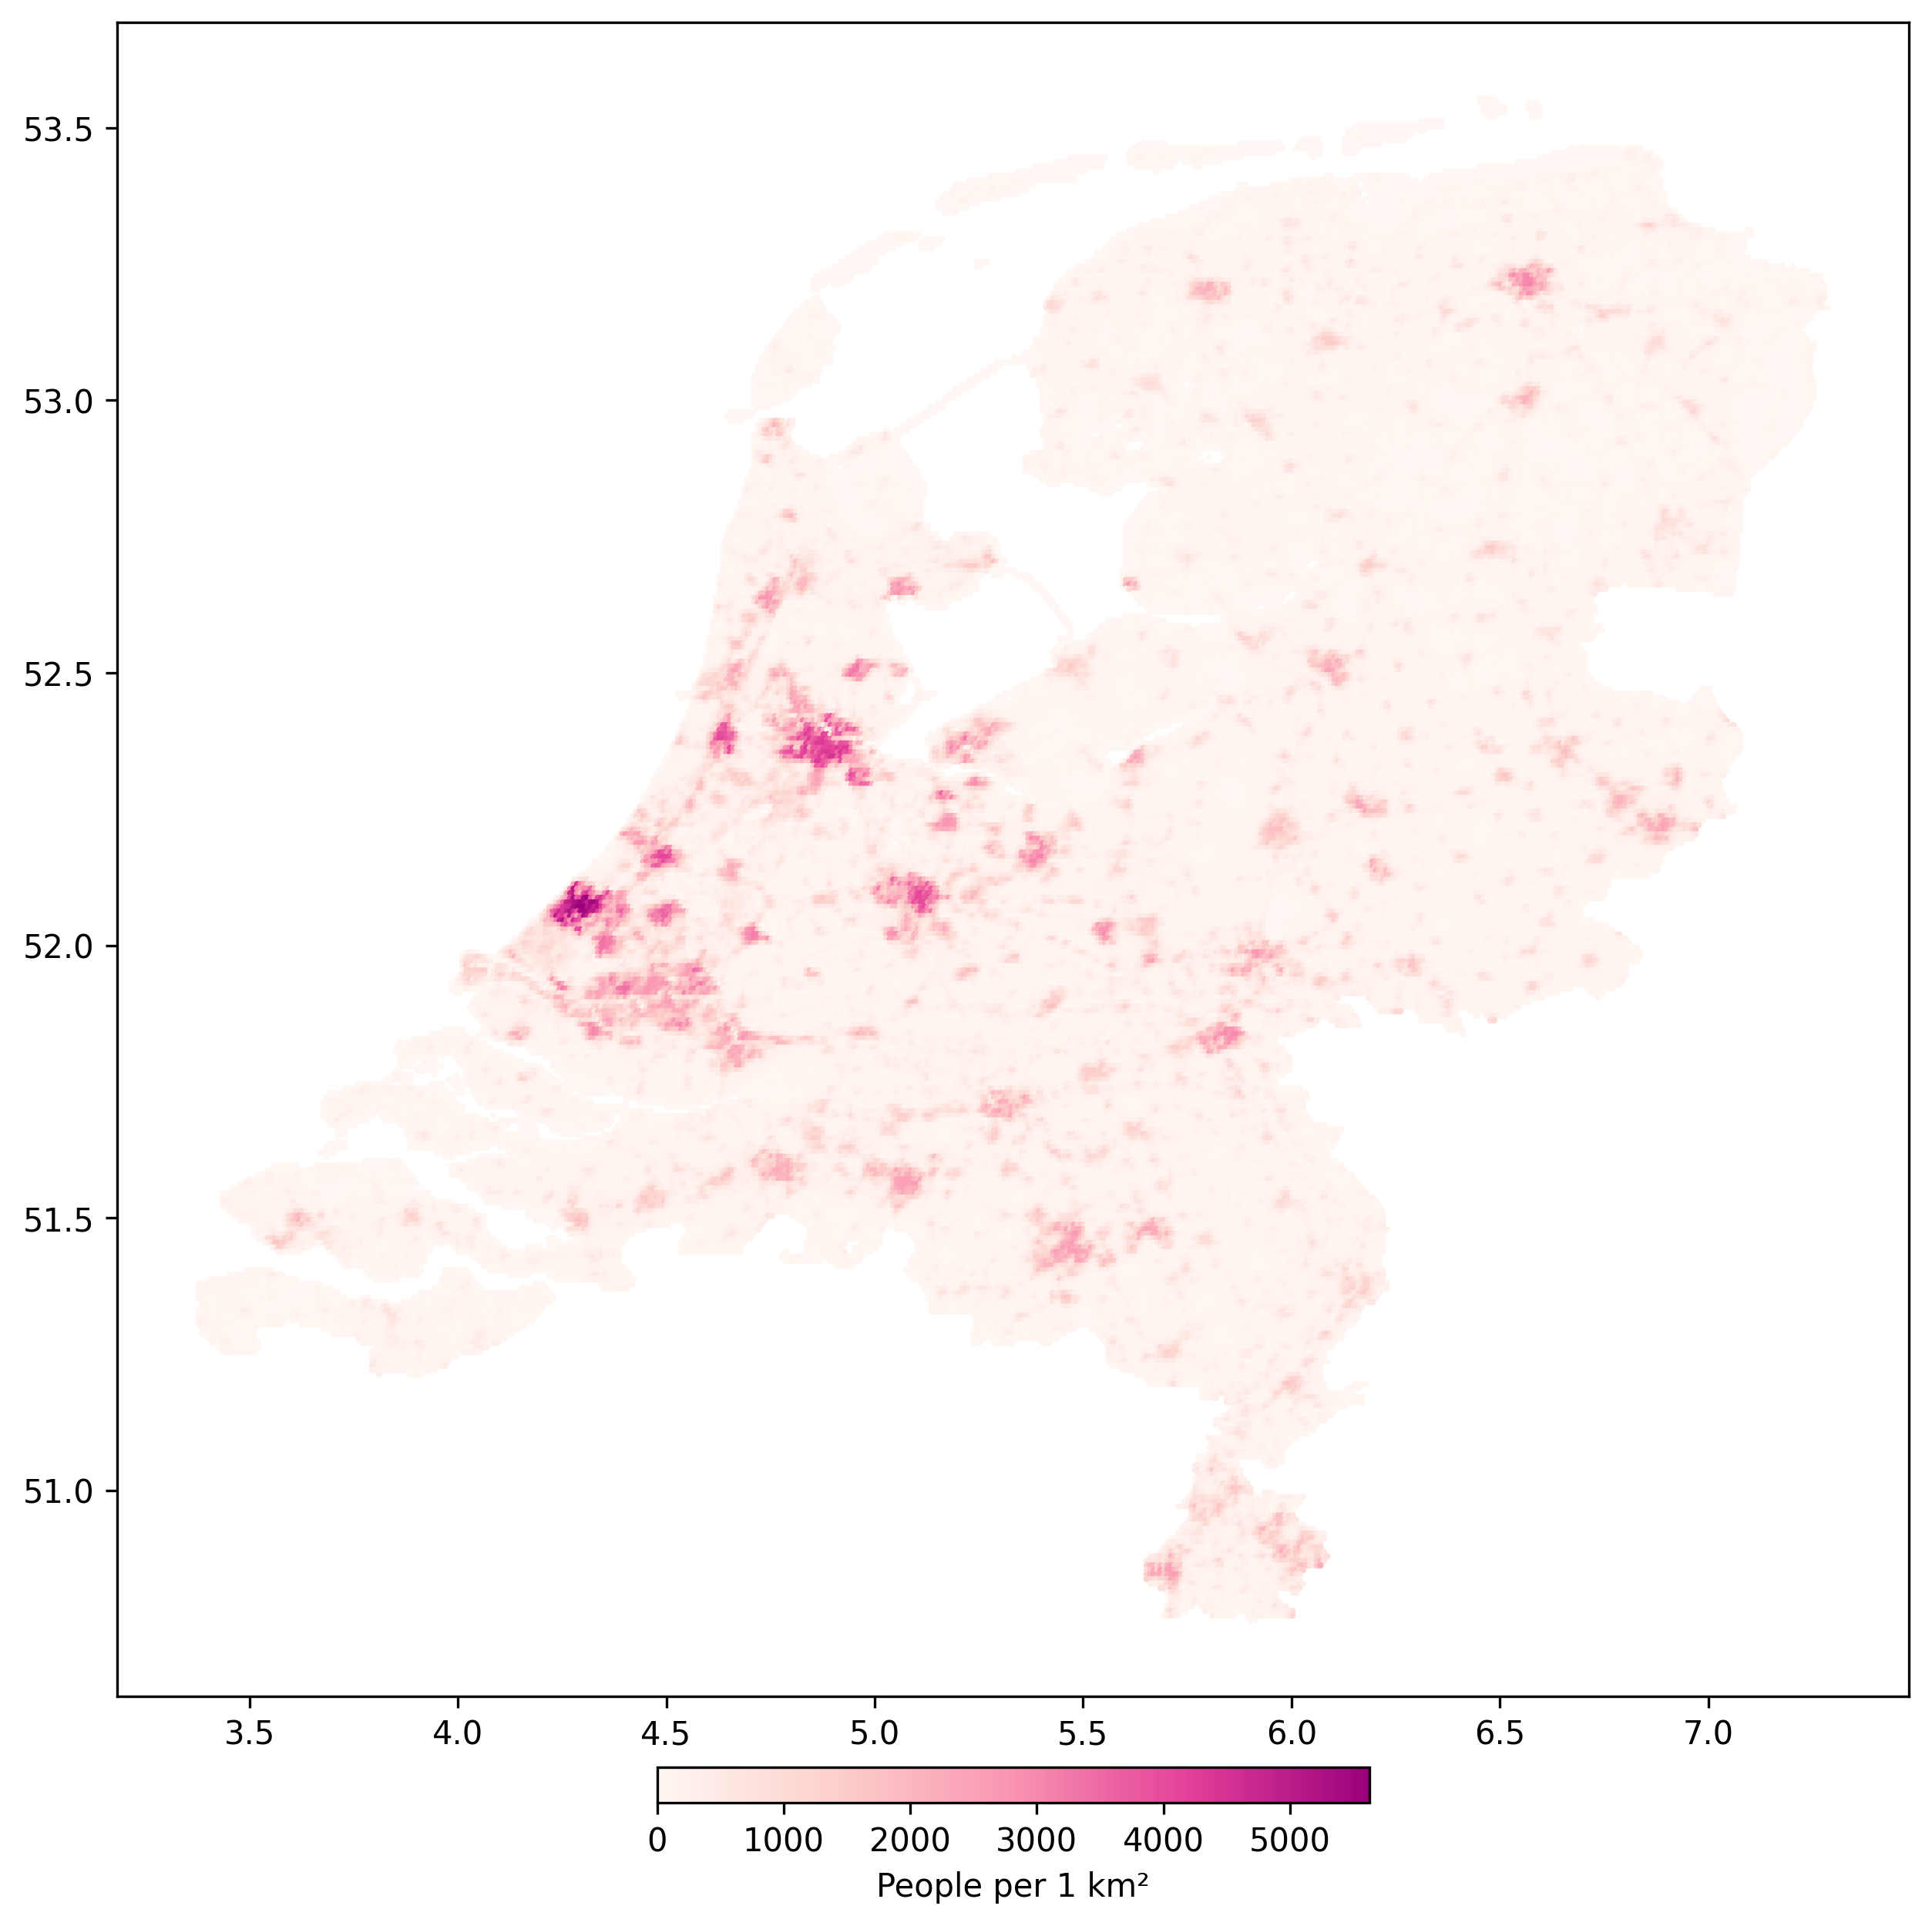

In [19]:
## CHOROPLETH MAP
#------------------

def theme_for_the_win():
    plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
    plt.grid(False)

cols = plt.cm.RdPu([i/5 for i in range(5)])
pal = LinearSegmentedColormap.from_list('RdPu', cols, N=512)

# Plotting without background map
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

# Add raster data
sc = ax.scatter(population_df['x'], population_df['y'], c=population_df['pop'],
                cmap=pal, norm=Normalize(vmin=population_df['pop'].min(), vmax=population_df['pop'].max()), s=1)

# Add colorbar
cbar = plt.colorbar(sc, orientation='horizontal', fraction=0.02, pad=0.04)
cbar.set_label('People per 1 km²')

# Apply theme
#theme_for_the_win()
plt.show()


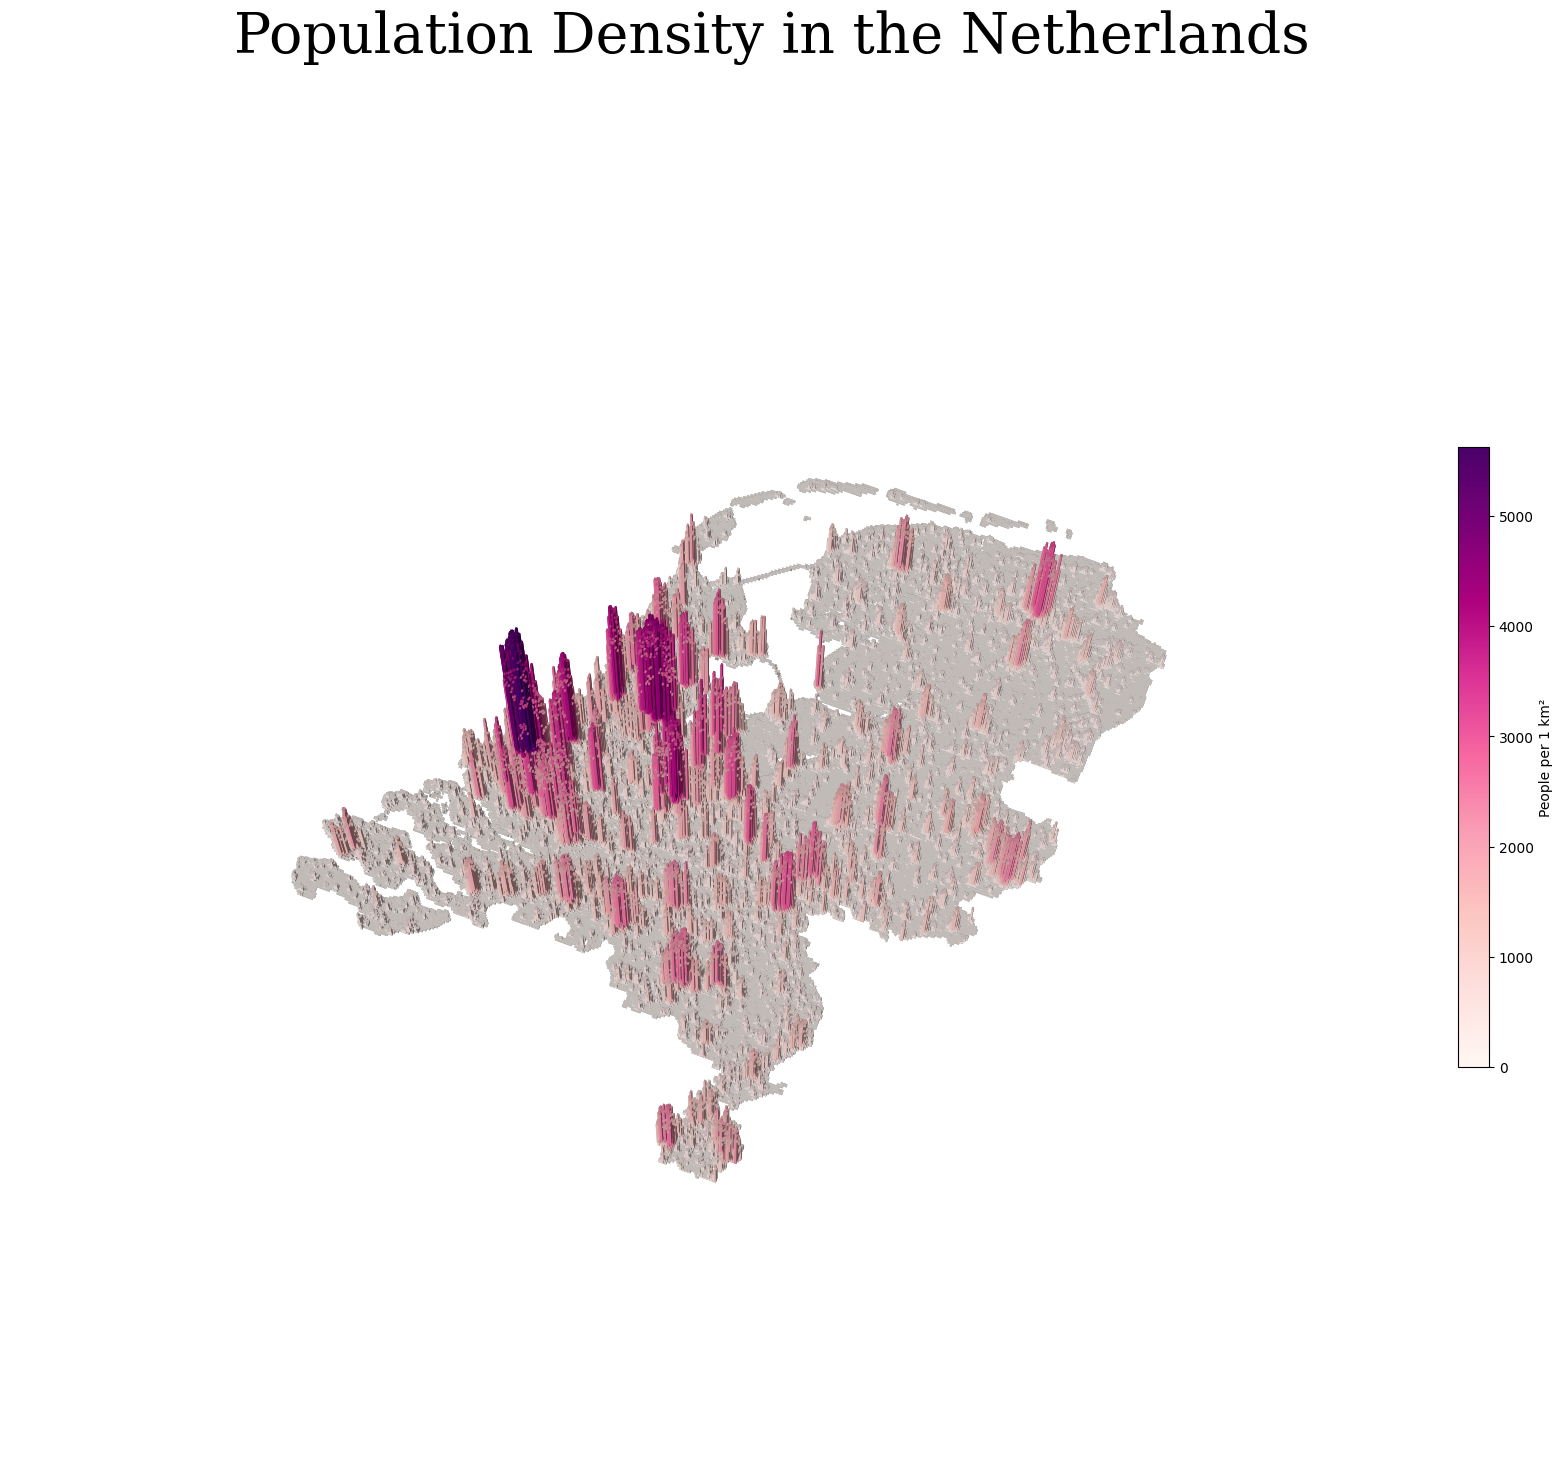

In [18]:
## SPIKES
#-------------------

# Set up the figure and 3D axis
fig = plt.figure(figsize=(20, 18), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.set_axis_off()



# Create 3D bars with color based on population density
bars = ax.bar3d(
    population_df['x'], 
    population_df['y'], 
    np.zeros_like(population_df['pop']), 
    0.01, 
    0.01, 
    population_df['pop'], 
    shade=True, 
    color=cm.RdPu((population_df['pop']) / population_df['pop'].max())
)

# Remove the grid and axis panes
ax.grid(False)

# Add a color bar
mappable = cm.ScalarMappable(cmap='RdPu')
mappable.set_array(population_df['pop'])
cbar = plt.colorbar(mappable, ax=ax, fraction=0.02, pad=0.04)
cbar.set_label('People per 1 km²')


# Set elevation and azimuth angles to rotate the plot to the front
ax.view_init(elev=80, azim=290)

# Set title
ax.set_title('Population Density in the Netherlands', fontsize=40, fontfamily='serif')
# Adjust title position
ax.title.set_position([0.55, -15])
# Show the plot
plt.show()

In [39]:
population_df.head()

,x,y,pop
0,6.452917,53.55375,0.296754
1,6.461250,53.55375,2.014291
2,6.469583,53.55375,3.075879
3,6.477917,53.55375,2.651478
4,6.486250,53.55375,0.584679


In [77]:

# Create a GeoDataFrame
_population_df = gpd.GeoDataFrame(population_df, geometry=gpd.points_from_xy(population_df['x'], population_df['y']), crs="EPSG:4326")
_population_df = _population_df.to_crs(epsg=3857)

In [78]:
# Generate grid data for contour plot
xi = np.linspace(_population_df['geometry'].x.min(), _population_df['geometry'].x.max(), 1000)
yi = np.linspace(_population_df['geometry'].y.min(), _population_df['geometry'].y.max(), 1000)
xi, yi = np.meshgrid(xi, yi)

# Try different interpolation methods
zi = griddata((_population_df['geometry'].x, _population_df['geometry'].y), _population_df['pop'], (xi, yi), method='nearest')


In [79]:
print("Number of NaN values in zi:", np.isnan(zi).sum())


Number of NaN values in zi: 0


In [82]:
zi

array([[7.92213974e+01, 7.92213974e+01, 7.92213974e+01, ...,
        9.12912109e+02, 9.12912109e+02, 9.12912109e+02],
       [7.92213974e+01, 7.92213974e+01, 7.92213974e+01, ...,
        9.12912109e+02, 9.12912109e+02, 9.12912109e+02],
       [7.92213974e+01, 7.92213974e+01, 7.92213974e+01, ...,
        9.12912109e+02, 9.12912109e+02, 9.12912109e+02],
       ...,
       [1.55721104e+00, 1.55721104e+00, 1.55721104e+00, ...,
        9.07956213e-02, 9.07956213e-02, 9.07956213e-02],
       [1.55721104e+00, 1.55721104e+00, 1.55721104e+00, ...,
        2.61485996e+01, 9.07956213e-02, 9.07956213e-02],
       [1.55721104e+00, 1.55721104e+00, 1.55721104e+00, ...,
        2.61485996e+01, 2.61485996e+01, 9.07956213e-02]])

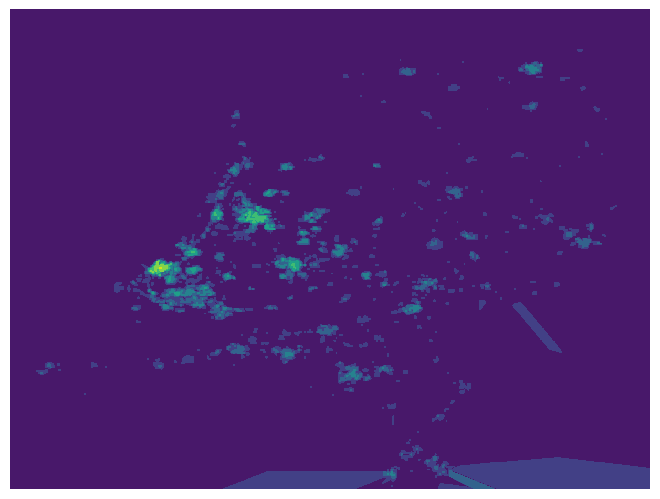

In [64]:
# Create a contour plot and save it as an image
fig, ax = plt.subplots()
contour = ax.contourf(xi, yi, zi, cmap='viridis')
plt.axis('off')
plt.gca().set_position([0, 0, 1, 1])  # Remove whitespace around the figure


In [85]:
m = folium.Map(location=[52.1, 5.2], zoom_start=8, tiles='OpenStreetMap')

# Reshape xi, yi, and zi into suitable format for HeatMapWithTime
x_mesh, y_mesh = np.meshgrid(xi, yi)
data = np.stack((x_mesh.flatten(), y_mesh.flatten(), zi.flatten()), axis=1)

# Assuming zi contains contour data, add it to the map
HeatMapWithTime(data, radius=15, gradient={0.1: 'blue', 0.3: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8).add_to(m)

# Display the map
m